In [1]:
import torch
import transformers

In [2]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random

In [3]:
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
from openai import OpenAI
from concurrent.futures import ThreadPoolExecutor

In [4]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("jinaai/jina-embeddings-v2-small-en")

Some weights of BertModel were not initialized from the model checkpoint at jinaai/jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.2.intermediate.dense.weight', 'encoder.layer.2.output.LayerNorm.bias', 'encoder.layer.2.output.LayerNorm.weight', 'encoder.layer.2.output.dense.bias', 'encoder.layer.2.output.dense.weight', 'encoder.layer.3.intermediate.dense.bias', 'encoder.layer.3.intermediate.den

In [5]:
# Load documents from processed JSON file
with open('../data/processed/documents-with-ids.json', 'r') as f:
    documents = json.load(f)

# Load ground truth dataset for evaluation from CSV file
df_ground_truth = pd.read_csv('../data/processed/ground-truth-retrieval.csv')
ground_truth = df_ground_truth.to_dict(orient='records')

print(f"Loaded {len(documents)} documents and {len(ground_truth)} ground truth questions")

Loaded 149 documents and 735 ground truth questions


In [6]:
documents[10]

{'location': 'Andhra_Pradesh',
 'doc_id': 'd4402d82c0',
 'content': "Andhra Pradesh is known for its rich history, architecture and culture. Andhra Pradesh has a variety of tourist attractions including beaches, hills, wildlife, forests and temples. Like rest of the Southern India, the culture of Andhra Pradesh is essentially Dravidian, quite different from North India's Sanskrit Hindu culture. Andhra Pradesh was part of the British Madras presidency and then independent India's Madras State until 1953, when Andhra State was formed, with the capital being",
 'id': '450a9d36'}

In [7]:
ground_truth[10]

{'question': 'What are the must-see religious temples to visit in Andhra Pradesh?',
 'id': 'db0beb52'}

In [8]:
# Create a merged dataframe by joining ground-truth with documents on 'id' column
df_documents = pd.DataFrame(documents)
df_merged = df_ground_truth.merge(df_documents, on='id', how='inner')
merged_data = df_merged.to_dict(orient='records')
with open('../data/processed/ques-docs-pairs.json', 'w') as f:
    json.dump(merged_data, f, indent=2)
    
print(f"Created merged dataset with {len(merged_data)} question-document pairs")
print(f"Sample merged record keys: {list(merged_data[0].keys()) if merged_data else 'No data'}")

Created merged dataset with 745 question-document pairs
Sample merged record keys: ['question', 'id', 'location', 'doc_id', 'content']


In [9]:
# Create document index for quick lookup
doc_idx = {d['id']: d for d in documents}

In [10]:
doc_idx['db0beb52']['content']

'Northern Coast (Alluri Sitharama Raju, Anakapalli, East Godavari, Kakinada, Konaseema, Parvathipuram Manyam, Srikakulam, Visakhapatnam, Vizianagaram, Yanam) Central Coast (Eluru, Krishna, NTR, West Godavari) Southern Coast (Bapatla, Guntur, Nellore, Palnadu, Prakasam, Tirupati) Rayalaseema (Annamayya, Anantapur, Chittoor, Kadapa, Kurnool, Nandyal, Sri Sathya Sai)  \n![0_image_1.png](0_image_1.png) interactive map'

 #### Index data

In [11]:
# We'll generate embeddings using [the sentence transformers](https://sbert.net/) library, if you don't have it, install it with pip:
# !pip install sentence-transformers

In [12]:
# Initialize sentence transformer model
model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

In [13]:
# Generate vectors for all documents
vectors = []
for doc in tqdm(documents):
    # Use content field instead of question + text
    content = doc['content']
    vector = model.encode(content)
    vectors.append(vector)

vectors = np.array(vectors)

  0%|          | 0/149 [00:00<?, ?it/s]

In [14]:
# Create vector search index
from minsearch import VectorSearch

vindex = VectorSearch(keyword_fields=['location'])
vindex.fit(vectors, documents)

### Retrieval


In [15]:
def minsearch_vector_search(vector, location):
    return vindex.search(
        vector,
        filter_dict={'location': location},
        num_results=5
    )

def question_text_vector(q):
    question = q['question']
    location = q.get('location', None)  # Get location if available, otherwise None
    v_q = model.encode(question)
    
    if location:
        return minsearch_vector_search(v_q, location)
    else:
        # If no location specified, search without filter
        return vindex.search(v_q, num_results=5)

In [16]:
# Test vector search functionality
test_question = {
    'question': 'What are the must-see religious sites in Andhra Pradesh?',
}
search_results = question_text_vector(test_question)
print(f"Found {len(search_results)} relevant documents")

Found 5 relevant documents


In [17]:
search_results

[{'location': 'Andhra_Pradesh',
  'doc_id': 'd4402d82c0',
  'content': 'Andhra Pradesh (AP) is a state in Southern India, with Bay of Bengal on the east and shares boundaries with Telangana on the north, Chhattisgarh and Odisha on the north-east, Tamil Nadu on the south and Karnataka on the west. Vijayawada is the capital of this state.',
  'id': 'a411c9aa'},
 {'location': 'Andhra_Pradesh',
  'doc_id': 'd4402d82c0',
  'content': "Andhra Pradesh is known for its rich history, architecture and culture. Andhra Pradesh has a variety of tourist attractions including beaches, hills, wildlife, forests and temples. Like rest of the Southern India, the culture of Andhra Pradesh is essentially Dravidian, quite different from North India's Sanskrit Hindu culture. Andhra Pradesh was part of the British Madras presidency and then independent India's Madras State until 1953, when Andhra State was formed, with the capital being",
  'id': '450a9d36'},
 {'location': 'Andhra_Pradesh',
  'doc_id': '9eb52

#### The RAG flow with Travel Assistant Prompt

In [18]:
def build_prompt(query, search_results):
    prompt_template = """
You're a travel assistant bot that helps users plan their itinerary and discover amazing places to visit.
Answer the QUESTION based on the CONTEXT from the travel database.
Use only the facts from the CONTEXT when answering the QUESTION.

When answering, consider:
- Must-visit tourist attractions and landmarks
- Cultural experiences and local traditions  
- Historical significance of places
- Best times to visit and travel tips
- Local cuisine and specialties (if mentioned in context)
- Transportation and accessibility information (if available)

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    for doc in search_results:
        location = doc.get('location', 'Unknown')
        content = doc.get('content', doc.get('text', ''))  # Handle both content and text fields
        context = context + f"location: {location}\ncontent: {content}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [19]:
# Initialize OpenAI client
client = OpenAI()

In [20]:
def llm(prompt, model='gpt-4o'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content

In [21]:
def rag(query: dict, model='gpt-4o') -> str:
    search_results = question_text_vector(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

#### Evaluation Across All Models

In [ ]:
# Select 25 random samples for evaluation across all models
random.seed(42)  # Set seed for reproducibility
sample_size = min(25, len(ground_truth))  # Use 25 or total available, whichever is smaller
sample_indices = random.sample(range(len(ground_truth)), sample_size)
sample_questions = [ground_truth[i] for i in sample_indices]

print(f"Selected {len(sample_questions)} random questions for evaluation")
print("Sample questions:")
for i, q in enumerate(sample_questions[:5]):  # Show first 5 samples
    print(f"{i+1}. {q['question']}")

Selected 25 random questions for evaluation
Sample questions:
1. Do foreign travelers need a visa and passport to visit Karnataka?
2. What is the historical importance of Penukonda in the context of the Vijayanagara empire?
3. What are the main cultural and spiritual centers to visit in Andhra Pradesh?
4. Which species of animals and birds might I encounter in Bandipur National Park?
5. What are some must-visit cultural and natural attractions in Karnataka?


In [23]:
# Prepare sample questions with their corresponding documents
sample_question_dicts = []
for sample_question in sample_questions:
    doc_id = sample_question['id']
    original_doc = doc_idx[doc_id]
    sample_location = original_doc.get('location', 'Unknown')
    
    question_dict = {
        'question': sample_question['question'],
        'location': sample_location,
        'id': doc_id,
        'answer_orig': original_doc['content']
    }
    sample_question_dicts.append(question_dict)

print(f"Prepared {len(sample_question_dicts)} question dictionaries for evaluation")

Prepared 25 question dictionaries for evaluation


In [24]:
# Test all GPT models on the 25 sample questions
models_to_test = ['gpt-3.5-turbo', 'gpt-4o', 'gpt-4o-mini']
multiple_example_results = []

for model_name in models_to_test:
    print(f"\nTesting model: {model_name}")
    model_results = []
    
    for i, sample_question_dict in enumerate(tqdm(sample_question_dicts, desc=f"Processing {model_name}")):
        try:
            answer_llm = rag(sample_question_dict, model=model_name)
            
            result = {
                'model': model_name,
                'question_index': i,
                'question': sample_question_dict['question'],
                'location': sample_question_dict['location'],
                'document_id': sample_question_dict['id'],
                'answer_orig': sample_question_dict['answer_orig'],
                'answer_llm': answer_llm
            }
            model_results.append(result)
            multiple_example_results.append(result)
            
        except Exception as e:
            print(f"Error with model {model_name} on question {i}: {e}")
            continue
    
    print(f"Completed {len(model_results)} evaluations for {model_name}")

print(f"\nTotal results generated: {len(multiple_example_results)}")



Testing model: gpt-3.5-turbo


Processing gpt-3.5-turbo:   0%|          | 0/25 [00:00<?, ?it/s]

Completed 25 evaluations for gpt-3.5-turbo

Testing model: gpt-4o


Processing gpt-4o:   0%|          | 0/25 [00:00<?, ?it/s]

Completed 25 evaluations for gpt-4o

Testing model: gpt-4o-mini


Processing gpt-4o-mini:   0%|          | 0/25 [00:00<?, ?it/s]

Completed 25 evaluations for gpt-4o-mini

Total results generated: 75


In [25]:
# Save multiple example results
df_multiple_examples = pd.DataFrame(multiple_example_results)
print(f"Created DataFrame with shape: {df_multiple_examples.shape}")
display(df_multiple_examples.head())

Created DataFrame with shape: (75, 7)


,model,question_index,question,location,document_id,answer_orig,answer_llm
0,gpt-3.5-turbo,0,Do foreign travelers need a visa and passport ...,Karnataka,7adcc584,of India. Served with brinjal curry (various t...,"No, foreign travelers do not need a visa and p..."
1,gpt-3.5-turbo,1,What is the historical importance of Penukonda...,Andhra_Pradesh,032385d9,a holy city with many temples Penukonda - Summ...,Penukonda holds historical importance as the s...
2,gpt-3.5-turbo,2,What are the main cultural and spiritual cente...,Andhra_Pradesh,dceae12c,- known as the cultural capital of Andhra Prad...,The main cultural and spiritual centers to vis...
3,gpt-3.5-turbo,3,Which species of animals and birds might I enc...,Karnataka,2ffbfa3d,Wildlife in Karnataka is administered under su...,"In Bandipur National Park in Karnataka, you ma..."
4,gpt-3.5-turbo,4,What are some must-visit cultural and natural ...,Karnataka,56d1a83b,Below is a selective list of sites of interest...,Some must-visit cultural and natural attractio...


In [26]:
df_multiple_examples.to_csv('../results/multiple_examples_comparison.csv', index=False)
print("Saved multiple example results to: results/multiple_examples_comparison.csv")

Saved multiple example results to: results/multiple_examples_comparison.csv


#### Cosine Similarity Metric 

In [27]:
def compute_similarity(record):
    """Calculate cosine similarity between original and LLM answers"""
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [28]:
# Calculate cosine similarities for all results
print("Computing cosine similarities for all results...")
cosine_similarities = []

for result in tqdm(multiple_example_results, desc="Computing similarities"):
    try:
        similarity = compute_similarity(result)
        cosine_similarities.append({
            'model': result['model'],
            'question_index': result['question_index'],
            'cosine_similarity': similarity,
            'question': result['question'],
            'document_id': result['document_id']
        })
    except Exception as e:
        print(f"Error computing similarity for {result['model']} question {result['question_index']}: {e}")

print(f"Computed {len(cosine_similarities)} similarity scores")

Computing cosine similarities for all results...


Computing similarities:   0%|          | 0/75 [00:00<?, ?it/s]

Computed 75 similarity scores


In [46]:
# Create aggregated statistics by model
df_similarities = pd.DataFrame(cosine_similarities)

In [73]:
# Calculate statistics for each model
similarity_stats = df_similarities.groupby('model')['cosine_similarity'].agg([
    'count', 'mean', 'std', 'min', 'max', 'median'
]).round(4)

print("Cosine Similarity Statistics by Model:")
print(similarity_stats)

Cosine Similarity Statistics by Model:
         count    mean     std     min     max  median
model                                                 
Model A     66  0.7565  0.0509  0.6341  0.9031  0.7530
Model B     61  0.7570  0.0481  0.6532  0.8892  0.7555
Model C     73  0.7413  0.0477  0.6453  0.8487  0.7366


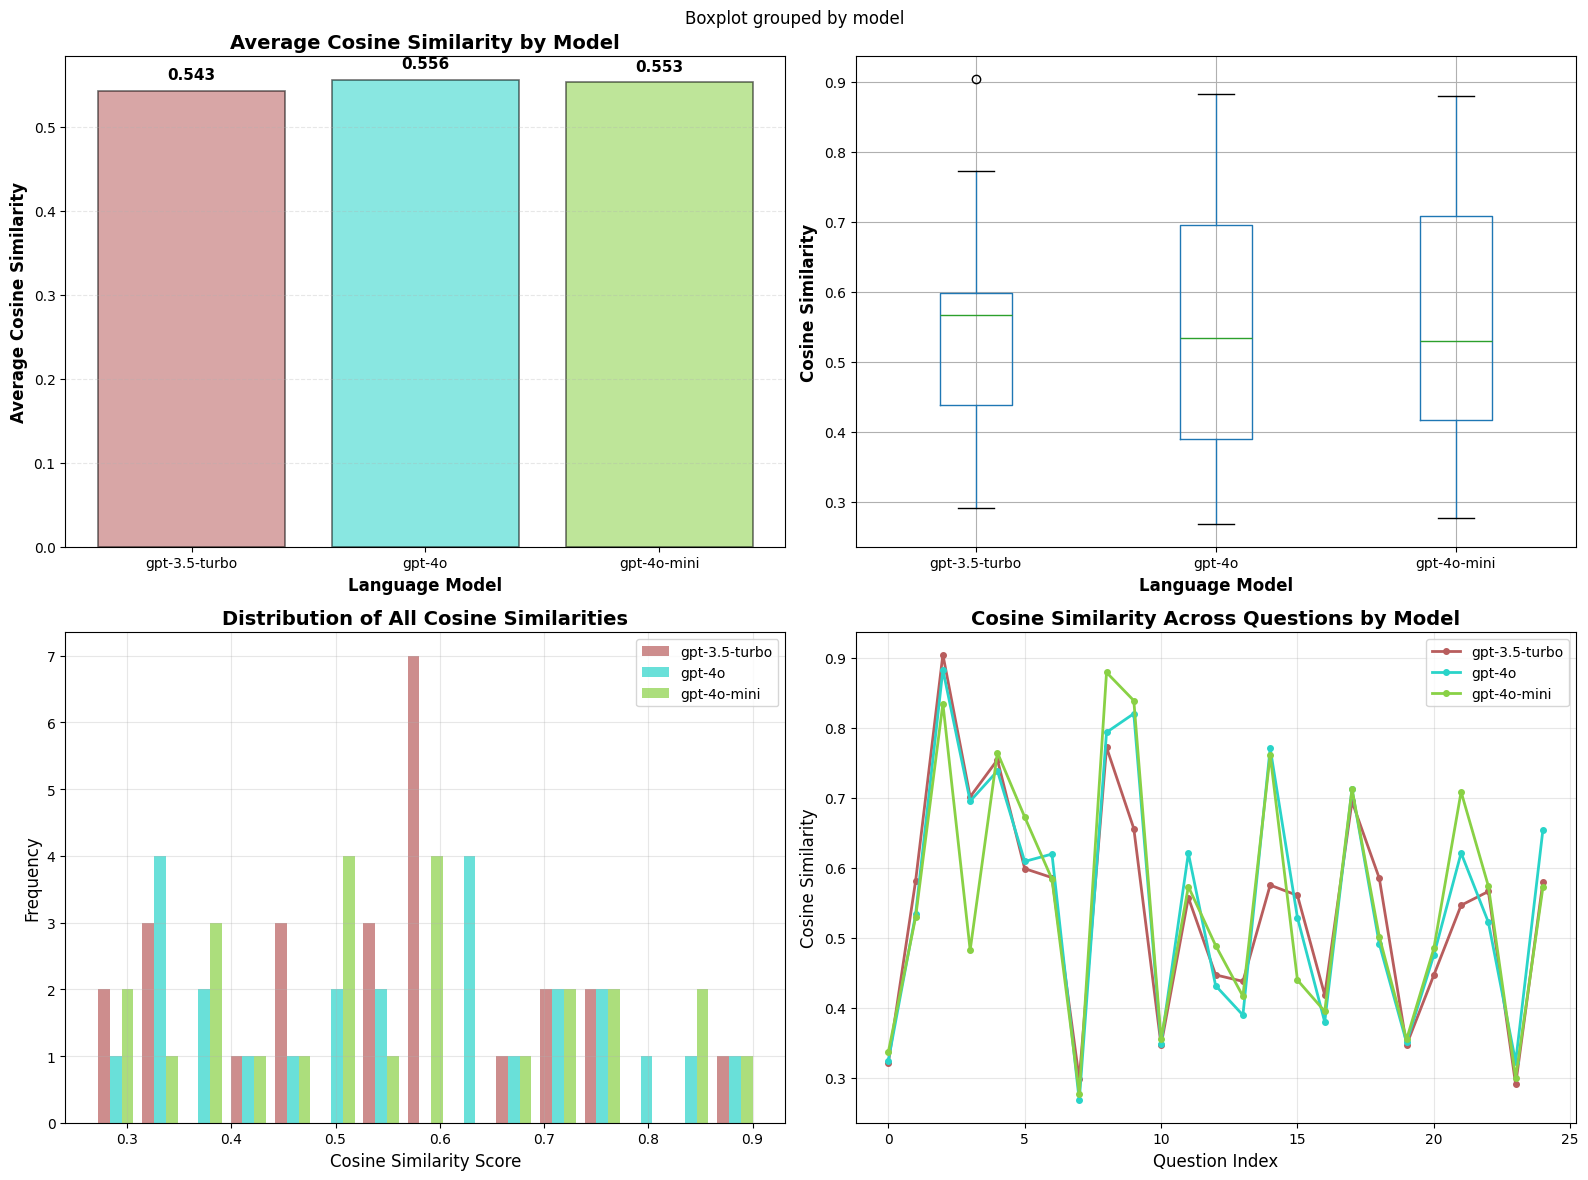

In [63]:
# Create comprehensive visualization for cosine similarities
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
plt.style.use('default')

# 1. Average cosine similarity by model (Bar chart)
avg_similarities = df_similarities.groupby('model')['cosine_similarity'].mean()
colors = ["#B85D5D", "#29D4C9", "#89D145"]
bars = ax1.bar(avg_similarities.index, avg_similarities.values, 
               color=colors, alpha=0.55, edgecolor='black', linewidth=1.2)

ax1.set_title('Average Cosine Similarity by Model', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Language Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('Average Cosine Similarity', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar, avg in zip(bars, avg_similarities.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{avg:.3f}', ha='center', va='bottom', 
             fontsize=11, fontweight='bold')

# 2. Box plot showing distribution of similarities
df_similarities.boxplot(column='cosine_similarity', by='model', ax=ax2)
ax2.set_title('Distribution of Cosine Similarities by Model')
ax2.set_xlabel('Language Model', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cosine Similarity', fontsize=12, fontweight='bold')
plt.setp(ax2, title='')  # Remove default boxplot title

# 3. Histogram of all similarities
ax3.hist([df_similarities[df_similarities['model'] == model]['cosine_similarity'] 
          for model in models_to_test], 
         bins=15, alpha=0.7, label=models_to_test, color=colors)
ax3.set_title('Distribution of All Cosine Similarities', fontsize=14, fontweight='bold')
ax3.set_xlabel('Cosine Similarity Score', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Line plot showing similarities across questions
for i, model in enumerate(models_to_test):
    model_data = df_similarities[df_similarities['model'] == model].sort_values('question_index')
    ax4.plot(model_data['question_index'], model_data['cosine_similarity'], 
             marker='o', label=model, color=colors[i], linewidth=2, markersize=4)

ax4.set_title('Cosine Similarity Across Questions by Model', fontsize=14, fontweight='bold')
ax4.set_xlabel('Question Index', fontsize=12)
ax4.set_ylabel('Cosine Similarity', fontsize=12)
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../images/cosine_similarity_multiple_examples.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

In [32]:
# Save similarities to CSV
df_similarities.to_csv('../results/cosine_similarities_multiple.csv', index=False)
similarity_stats.to_csv('../results/cosine_similarity_stats.csv')
print("Saved detailed similarities to: results/cosine_similarities_multiple.csv")
print("Saved summary statistics to: results/cosine_similarity_stats.csv")

Saved detailed similarities to: results/cosine_similarities_multiple.csv
Saved summary statistics to: results/cosine_similarity_stats.csv


#### LLM-as-a-Judge Evaluation

In [33]:
# LLM-as-a-Judge evaluation prompts
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

#### Evaluate all models using LLM-as-a-Judge (A>Q>A evaluation)


In [34]:
# Sample a subset for evaluation to manage API costs (first 25 results per model)
evaluation_sample_size = min(25, len(sample_questions))
sample_results_for_eval = []

for model in models_to_test:
    model_results = [r for r in multiple_example_results if r['model'] == model][:evaluation_sample_size]
    sample_results_for_eval.extend(model_results)

print(f"Selected {len(sample_results_for_eval)} results for LLM-as-a-Judge evaluation")

Selected 75 results for LLM-as-a-Judge evaluation


In [35]:
evaluations_aqa = []

print("Running Answer-Question-Answer evaluations...")
for result in tqdm(sample_results_for_eval, desc="AQA Evaluation"):
    prompt = prompt1_template.format(**result)
    try:
        evaluation_str = llm(prompt, model='gpt-4o-mini')
        evaluation = json.loads(evaluation_str)
        evaluation['model'] = result['model']
        evaluation['question_index'] = result['question_index']
        evaluation['evaluation_type'] = 'Answer-Question-Answer'
        evaluations_aqa.append(evaluation)
    except (json.JSONDecodeError, Exception) as e:
        print(f"Failed to parse evaluation for model {result['model']}, question {result['question_index']}: {e}")

print(f"Completed {len(evaluations_aqa)} AQA evaluations")

Running Answer-Question-Answer evaluations...


AQA Evaluation:   0%|          | 0/75 [00:00<?, ?it/s]

Completed 75 AQA evaluations


#### Evaluate all models using LLM-as-a-Judge (Q>A evaluation)


In [36]:
evaluations_qa = []

print("Running Question-Answer evaluations...")
for result in tqdm(sample_results_for_eval, desc="QA Evaluation"):
    prompt = prompt2_template.format(**result)
    try:
        evaluation_str = llm(prompt, model='gpt-4o-mini')
        evaluation = json.loads(evaluation_str)
        evaluation['model'] = result['model']
        evaluation['question_index'] = result['question_index']
        evaluation['evaluation_type'] = 'Question-Answer'
        evaluations_qa.append(evaluation)
    except (json.JSONDecodeError, Exception) as e:
        print(f"Failed to parse evaluation for model {result['model']}, question {result['question_index']}: {e}")

print(f"Completed {len(evaluations_qa)} QA evaluations")

Running Question-Answer evaluations...


QA Evaluation:   0%|          | 0/75 [00:00<?, ?it/s]

Completed 75 QA evaluations


In [37]:
# Combine all evaluations
all_evaluations = evaluations_aqa + evaluations_qa
df_evaluations = pd.DataFrame(all_evaluations)

In [38]:
# Display evaluation results summary
print("LLM-as-a-Judge Evaluation Summary:")
evaluation_summary = df_evaluations.groupby(['evaluation_type', 'model', 'Relevance']).size().unstack(fill_value=0)
print(evaluation_summary)

LLM-as-a-Judge Evaluation Summary:
Relevance                             NON_RELEVANT  PARTLY_RELEVANT  RELEVANT
evaluation_type        model                                                 
Answer-Question-Answer gpt-3.5-turbo             7               13         5
                       gpt-4o                    8                9         8
                       gpt-4o-mini               9                8         8
Question-Answer        gpt-3.5-turbo             1                4        20
                       gpt-4o                    1                5        19
                       gpt-4o-mini               0                3        22


In [39]:
# Save LLM-as-a-Judge evaluations
df_evaluations.to_csv('../results/llm_as_a_judge_evaluations_multiple.csv', index=False)
print("Saved LLM-as-a-Judge evaluations to: results/llm_as_a_judge_evaluations_multiple.csv")

Saved LLM-as-a-Judge evaluations to: results/llm_as_a_judge_evaluations_multiple.csv


#### Summary Results

In [45]:
# Create comprehensive summary report
print("=" * 60)
print("COMPREHENSIVE EVALUATION SUMMARY (25 Random Questions)")
print("=" * 60)

print(f"\nDATASET INFO:")
print(f"   Total questions evaluated: {len(sample_questions)}")
print(f"   Total model responses: {len(multiple_example_results)}")
print(f"   Models tested: {', '.join(models_to_test)}")

print(f"\n1. COSINE SIMILARITY STATISTICS:")
print("-" * 40)
for model in models_to_test:
    model_sims = df_similarities[df_similarities['model'] == model]['cosine_similarity']
    print(f"   {model}:")
    print(f"      Mean: {model_sims.mean():.4f}")
    print(f"      Std:  {model_sims.std():.4f}")
    print(f"      Min:  {model_sims.min():.4f}")
    print(f"      Max:  {model_sims.max():.4f}")
    print(f"      Median: {model_sims.median():.4f}")

print(f"\n2. LLM-as-a-JUDGE EVALUATION RESULTS:")
print("-" * 40)

if not aqa_data.empty:
    print(f"\n   Answer-Question-Answer Relevance (Sample of {evaluation_sample_size} per model):")
    aqa_summary = aqa_data.groupby(['model', 'Relevance']).size().unstack(fill_value=0)
    for model in aqa_summary.index:
        print(f"   {model}:")
        for relevance in aqa_summary.columns:
            count = aqa_summary.loc[model, relevance]
            if count > 0:
                print(f"      {relevance}: {count}")

if not qa_data.empty:
    print(f"\n   Question-Answer Relevance (Sample of {evaluation_sample_size} per model):")
    qa_summary = qa_data.groupby(['model', 'Relevance']).size().unstack(fill_value=0)
    for model in qa_summary.index:
        print(f"   {model}:")
        for relevance in qa_summary.columns:
            count = qa_summary.loc[model, relevance]
            if count > 0:
                print(f"      {relevance}: {count}")

print(f"\n3. PERFORMANCE RANKING (by Average Cosine Similarity):")
print("-" * 40)
model_rankings = df_similarities.groupby('model')['cosine_similarity'].mean().sort_values(ascending=False)
for i, (model, score) in enumerate(model_rankings.items(), 1):
    medals = ["🥇", "🥈", "🥉"]
    medal = medals[i-1] if i <= 3 else f"{i}."
    print(f"   {medal} {model}: {score:.4f}")

print(f"\n4. FILES GENERATED:")
print("-" * 40)
print("   - results/multiple_examples_comparison.csv")
print("   - results/cosine_similarities_multiple.csv") 
print("   - results/cosine_similarity_stats.csv")
print("   - results/llm_as_a_judge_evaluations_multiple.csv")
print("   - data/processed/ques-docs-pairs.json")

print("\n" + "=" * 60)

COMPREHENSIVE EVALUATION SUMMARY (25 Random Questions)

DATASET INFO:
   Total questions evaluated: 25
   Total model responses: 75
   Models tested: gpt-3.5-turbo, gpt-4o, gpt-4o-mini

1. COSINE SIMILARITY STATISTICS:
----------------------------------------
   gpt-3.5-turbo:
      Mean: 0.5429
      Std:  0.1574
      Min:  0.2907
      Max:  0.9042
      Median: 0.5662
   gpt-4o:
      Mean: 0.5562
      Std:  0.1760
      Min:  0.2679
      Max:  0.8826
      Median: 0.5335
   gpt-4o-mini:
      Mean: 0.5535
      Std:  0.1779
      Min:  0.2773
      Max:  0.8788
      Median: 0.5294

2. LLM-as-a-JUDGE EVALUATION RESULTS:
----------------------------------------

   Answer-Question-Answer Relevance (Sample of 25 per model):
   gpt-3.5-turbo:
      NON_RELEVANT: 7
      PARTLY_RELEVANT: 13
      RELEVANT: 5
   gpt-4o:
      NON_RELEVANT: 8
      PARTLY_RELEVANT: 9
      RELEVANT: 8
   gpt-4o-mini:
      NON_RELEVANT: 9
      PARTLY_RELEVANT: 8
      RELEVANT: 8

   Question-Answer 